In [2]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from PIL import Image
from tifffile import imread, imwrite
import tifffile as tiff
import os
import albumentations as A

 <font size="6">  Image segmentation training - Mask R-CNN </font> 

---

## Set path and Load library


In [3]:
from mrcnn.main import *
# Set path to Mask RCNN folder
ROOT_DIR = os.path.abspath("/home/ubuntu/github/MaskRCNN")
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


In [4]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 
from mrcnn.config import Config
COCO_MODEL_PATH = "mask_rcnn_coco.h5"
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Load data

In [5]:
#Training images should be square
size=256

images = sorted((glob.glob("trainingData/*Nuclei.jpg")))
labels = sorted((glob.glob("trainingData/*Detections.tiff")))

images_val = sorted((glob.glob("trainingData/*Nuclei.jpg")))
labels_val = sorted((glob.glob("trainingData/*Detections.tiff")))
labels

['trainingData4\\B32Detections.tiff',
 'trainingData4\\D35Detections.tiff',
 'trainingData4\\F11Detections.tiff',
 'trainingData4\\H32Detections.tiff',
 'trainingData4\\K27Detections.tiff',
 'trainingData4\\L28Detections.tiff',
 'trainingData4\\P42Detections.tiff',
 'trainingData4\\P43Detections.tiff',
 'trainingData4\\S10Detections.tiff',
 'trainingData4\\T37Detections.tiff',
 'trainingData4\\W14Detections.tiff',
 'trainingData4\\X35Detections.tiff']

## Set parameters for training

Key parameter
* GPU count
* IMAGES_PER_GPU
* DETECTION_MAX_INSTANCES: max instance in one image
* IMAGE_MIN_DIM: random cropping will be performed on the input image to this size. I recommend 128 for 200X image.


In [6]:
class CellConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    NAME = "cell"
    BACKBONE = 'resnet50'
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    #RPN_NMS_THRESHOLD = 0.8
    DETECTION_MAX_INSTANCES = 1000 #500
    MAX_GT_INSTANCES = 1000
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 cell
    # Use small images for faster training.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256 #128
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256 #1024
    IMAGE_RESIZE_MODE = 'crop'
    ROI_POSITIVE_RATIO = 0.33
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels
    # Reduce training ROIs per image because the images are small and have
    # few objects
    TRAIN_ROIS_PER_IMAGE = 1000
    # Uses a small epoch since the data is simple
    STEPS_PER_EPOCH = 100 #1000 
    VALIDATION_STEPS =50
    MEAN_PIXEL = np.array([0,0,0]
    
    
config = CellConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1000
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

## Load data and configuration into model

Image Count: 12
Class Count: 2
  0. BG                                                
  1. cell                                              
{'id': 0, 'source': 'cell', 'path': 'trainingData4\\B32Nuclei.jpg', 'x_offset': 0, 'y_offset': 0}


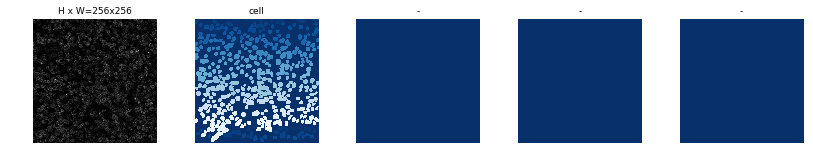

{'id': 1, 'source': 'cell', 'path': 'trainingData4\\D35Nuclei.jpg', 'x_offset': 0, 'y_offset': 0}


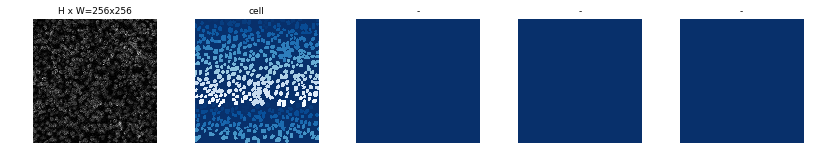

{'id': 2, 'source': 'cell', 'path': 'trainingData4\\F11Nuclei.jpg', 'x_offset': 0, 'y_offset': 0}


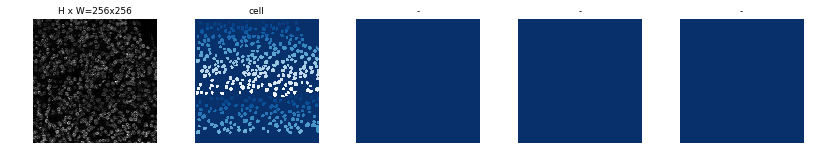

{'id': 3, 'source': 'cell', 'path': 'trainingData4\\H32Nuclei.jpg', 'x_offset': 0, 'y_offset': 0}


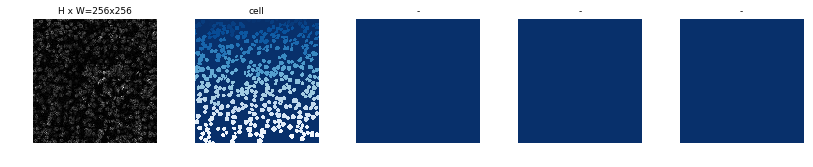

{'id': 4, 'source': 'cell', 'path': 'trainingData4\\K27Nuclei.jpg', 'x_offset': 0, 'y_offset': 0}


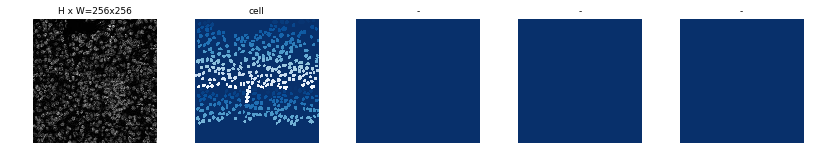

In [8]:
config = CellConfig()
# config.display()

# Training dataset
dataset_train = CellDataset()
dataset_train.setImages(images)
dataset_train.setLabels(labels)
dataset_train.setSize(size)
dataset_train.load_cells('dummy_path')
dataset_train.prepare()

# Validation dataset --> Same for now
dataset_val = CellDataset()
dataset_val.setImages(images)
dataset_val.setLabels(labels)
dataset_val.setSize(size)
dataset_val.load_cells('dummy_path')
dataset_val.prepare()

print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
for i in range(0,min(len(images),5)):
    image = dataset_train.load_image(i)
    mask, class_ids = dataset_train.load_mask(i)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Training configuration

### Model backend and Pre-trained weights

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
init_with = "imagnet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Loads weights trained on MS COCO, but skips layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model.load_weights(model.find_last()[1], by_name=True)

### Data Augmentation

In [10]:
#Data Augmentation

augmentation = iaa.SomeOf((0, 5), [
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
        iaa.Affine(rotate=(-90,90)),
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0,5.0)))
    ,iaa.Sometimes(0.2, iaa.Affine(scale={"x": (0.7, 1.5), "y": (0.7, 1.5)})),
    iaa.Sometimes(0.2,  iaa.Multiply((0.7, 1.5))),
    iaa.Sometimes(0.1, iaa.Affine(shear=(-45, 45)))
])


## Train

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20,augmentation=augmentation,
            layers='all') #all

